In [4]:
import os
import sys
import glob
import pickle
import itertools
import random

from IPython.display import Image

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import ListedColormap
from scipy.stats import multivariate_normal

import numpy as np
import pandas as pd
from scipy.stats import beta


random.seed(1234)
%matplotlib inline

## Mondrian Processes

### Various Functions for Mondrian Processes

Sampling...

In [5]:
### SAMPLE MONDRIAN PROCESS ###
def draw_Mondrian(theta_space, budget=5):
    return draw_Mondrian_at_t(theta_space, 0, budget)
    
def draw_Mondrian_at_t(theta_space, t, budget):
    dists = theta_space[:,1] - theta_space[:,0]
    lin_dim = np.sum(dists)
    T = np.random.exponential(scale=1./lin_dim)
    
    if t+T > budget: 
        return (theta_space, None, None)
    
    d = np.argmax(np.random.multinomial(n=1, pvals=dists/lin_dim))
    x = np.random.uniform(low=theta_space[d,0], high=theta_space[d,1])
    
    theta_left = np.copy(theta_space)
    theta_left[d][1] = x 
    M_left = draw_Mondrian_at_t(theta_left, t+T, budget)
    
    theta_right = np.copy(theta_space)
    theta_right[d][0] = x 
    M_right = draw_Mondrian_at_t(theta_right, t+T, budget)
    
    return (theta_space, M_left, M_right)

def comp_log_p_sample(theta_space, data):
    if theta_space[1] == None and theta_space[2] == None:
        if data.shape[0] == 0:
            return 0
        else:
            mu = np.mean(data, axis = 0)
            residual = data - mu
            cov = np.dot(residual.T , residual) / data.shape[0] + np.identity(data.shape[1])*0.001
            return np.log(multivariate_normal.pdf(data, mean=mu, cov=cov)).sum()
    
    # find the dimension and location of first cut
    root_rec = theta_space[0]
    left_rec = theta_space[1][0]
    
    for _ in range(root_rec.shape[0]):
        if root_rec[_,1] != left_rec[_,1]:
            break
    
    dim, pos = _, left_rec[_,1]
    idx_left = data[:,dim] < pos
    idx_right = data[:,dim] >= pos
    log_len_left =  np.log(pos - root_rec[dim,0])
    log_len_right = np.log(root_rec[dim,1] - pos)
    return comp_log_p_sample(theta_space[1], data[idx_left]) + comp_log_p_sample(theta_space[2], data[idx_right])    

Visualization...

In [6]:
### VISUALIZE 2D MONDRIAN PROCESS ###
def print_partitions(p, trans_level=1., color='k'):
    if not p[1] and not p[2]: 
        plt.plot([p[0][0,0], p[0][0,0]], [p[0][1,0], p[0][1,1]], color+'-', linewidth=3, alpha=trans_level)
        plt.plot([p[0][0,1], p[0][0,1]], [p[0][1,0], p[0][1,1]], color+'-', linewidth=3, alpha=trans_level)
        plt.plot([p[0][0,0], p[0][0,1]], [p[0][1,0], p[0][1,0]], color+'-', linewidth=3, alpha=trans_level)
        plt.plot([p[0][0,0], p[0][0,1]], [p[0][1,1], p[0][1,1]], color+'-', linewidth=3, alpha=trans_level)
    
    else:
        print_partitions(p[1], trans_level, color)
        print_partitions(p[2], trans_level, color)
        
        
### VISUALIZE 2D POSTERIOR WITH DATA###
def print_posterior(data, samples, trans_level=.05, color='k'):

    plt.figure()
    plt.scatter(data[:,0], data[:,1], c='k', edgecolors='k', s=5, alpha=.5)

    #print all samples
    for sample in samples:
        print_partitions(sample, trans_level, color)
        
        
def print_tree_at_leaf(mp_tree, table):

    if mp_tree[1] == None and mp_tree[2] == None: 
        print table.shape
        return 1
    
    
    # find the dimension and location of first cut
    root_rec = mp_tree[0]
    left_rec = mp_tree[1][0]
    
    for _ in range(root_rec.shape[0]):
        if root_rec[_,1] != left_rec[_,1]:
            break
    d, pos = _, left_rec[_,1]
    
    cut_type = ' '.join([str(int(x)) for x in sorted(set(table[table.columns[d]]))]) 
    
    if cut_type in {"-1 0 1", '-1 1'}: 
        idx_table_left = table[table.columns[d]] != 1
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[d]] != -1
        table_right = table.loc[idx_table_right]
    
    if cut_type == '-1 0':
        idx_table_left = table[table.columns[d]] == -1
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[d]] == 0
        table_right = table.loc[idx_table_right]
        

    if cut_type == '0 1':
        idx_table_left = table[table.columns[d]] == 0
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[d]] == 1
        table_right = table.loc[idx_table_right]
    
    return print_tree_at_leaf(mp_tree[1], table_left) + print_tree_at_leaf(mp_tree[2], table_right)


## Mondrian Process Generative Model

We apply Mondrian Processes (MPs) to flow cytometry data, using the prior information in the table above to guide the axis-aligned cuts.  Instead of uniformly, we draw the cut proportion from $w \sim \text{Beta}(a_{0}, b_{0})$. 

Now let's re-implement the MP sampling function, accounting for the prior information...

In [7]:
### SAMPLE MONDRIAN PROCESS WITH PRIOR INFORMATION ###
def draw_informed_Mondrian(theta_space, table, budget=5):
    
    # INFORMATIVE PRIORS
    upper_cut = (5., 2.)
    lower_cut = (2., 5.)
    middle_cut = (5., 5.)
    neutral_cut = (2., 2.)
    priors_dict = { '-1':lower_cut, '0':neutral_cut, '1':upper_cut, 
                   '-1 0':lower_cut, '-1 1':middle_cut, '0 1':upper_cut,
                   '-1 0 1': middle_cut, '': neutral_cut
                  }
    
    cut_history = [1] * theta_space.shape[0]
    
    return draw_informed_Mondrian_at_t(theta_space, table, priors_dict, cut_history)
    

def draw_informed_Mondrian_at_t(theta_space, table, priors_dict, cut_history):    
    
    if sum(cut_history) == 0 or table.shape[0] == 1:
        return (theta_space, None, None)

    
    types_str = [' '.join([str(int(x)) for x in sorted(set(table[table.columns[d]]))]) 
                 for d in range(table.shape[1])]
    
    if set([types_str[d] for d in range(table.shape[1]) if cut_history[d] == 1]).issubset({'0','1','-1'}):
        return (theta_space, None, None)

    
    low, medium, high, very_high = 0, 1, 100, 1000
    priority_dict = {'-1': low , '0': low, '1': low, 
                   '-1 0': medium, '0 1': medium,
                   '-1 0 1': high, '-1 1':very_high
    }    
        
    types = np.array([priority_dict[_] for _ in types_str])
    

    dists = (theta_space[:,1] - theta_space[:,0])* types    
    lin_dim = np.sum(dists)
    # draw dimension to cut
    dim_probs = ((dists/lin_dim) * np.array(cut_history)) 
    dim_probs /= np.sum(dim_probs)
    d = np.argmax(np.random.multinomial(n=1, pvals=dim_probs))
    cut_history[d] = 0

    prior_type_str = ' '.join([str(int(x)) for x in sorted(set(table[table.columns[d]]))])
    prior_params = priors_dict[prior_type_str]
    
    # make scaled cut
    x = (theta_space[d,1] - theta_space[d,0]) * np.random.beta(prior_params[0], prior_params[1]) + theta_space[d,0]
    
    cut_type = types_str[d]
    
    if cut_type in {"-1 0 1", '-1 1'}: 
        idx_table_left = table[table.columns[d]] != 1
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[d]] != -1
        table_right = table.loc[idx_table_right]
    
    if cut_type == '-1 0':
        idx_table_left = table[table.columns[d]] == -1
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[d]] == 0
        table_right = table.loc[idx_table_right]
        

    if cut_type == '0 1':
        idx_table_left = table[table.columns[d]] == 0
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[d]] == 1
        table_right = table.loc[idx_table_right]

    
    # make lower partition
    theta_left = np.copy(theta_space)
    theta_left[d][1] = x
    M_left = draw_informed_Mondrian_at_t(theta_left, table_left, priors_dict, list(cut_history))
    
    # make upper partition
    theta_right = np.copy(theta_space)
    theta_right[d][0] = x 
    M_right = draw_informed_Mondrian_at_t(theta_right, table_right, priors_dict,list(cut_history))
    
    return (theta_space, M_left, M_right)

def Mondrian_Gaussian_perturbation(theta_space, old_sample, stepsize):
    """
    Input: 
    theta_space: a rectangle
    old_sample: partioned theta_space of a mondrian process
    stepsize: gaussian std
    """
    if old_sample[1] == None and old_sample[2] == None:
        return (theta_space, None, None)
    
    # find the dimension and location of first cut in the old_sample
    for _ in range(old_sample[0].shape[0]):
        if old_sample[0][_,1] > old_sample[1][0][_,1]:
            break    
    dim, pos = _, old_sample[1][0][_,1]
    # propose position of new cut
    good_propose = False
    while good_propose == False:
        new_pos = pos + np.random.normal(0,(old_sample[0][dim,1] - old_sample[0][dim,0])*stepsize,1)[0]
        if new_pos < theta_space[dim,1] and new_pos > theta_space[dim,0]:
            good_propose = True
    
    theta_left = np.copy(theta_space)
    theta_left[dim,1] = new_pos
    theta_right = np.copy(theta_space)
    theta_right[dim,0] = new_pos
    
    new_M_left= Mondrian_Gaussian_perturbation(theta_left, old_sample[1], stepsize)
    new_M_right = Mondrian_Gaussian_perturbation(theta_right, old_sample[2], stepsize)
    
    return (theta_space, new_M_left, new_M_right)

def comp_log_p_prior(theta_space, table, cut_history):
    """
    This function returns prior probability of a Mondrian process theta_space
    """
    if theta_space[1] == None and theta_space[2] == None:
        return 0
    
    log_prior = 0
    

    # INFORMATIVE PRIORS
    upper_cut = (5., 2.)
    lower_cut = (2., 5.)
    middle_cut = (5., 5.)
    neutral_cut = (2., 2.)
    priors_dict = { '-1':lower_cut, '0':neutral_cut, '1':upper_cut, 
                   '-1 0':lower_cut, '-1 1':middle_cut, '0 1':upper_cut,
                   '-1 0 1': middle_cut, '': neutral_cut
                  }
    
    
    # find the dimension and location of first cut
    root_rec = theta_space[0]
    left_rec = theta_space[1][0]
    
    for _ in range(root_rec.shape[0]):
        if root_rec[_,1] != left_rec[_,1]:
            break
    dim  = _
    beta_pos =  (left_rec[_,1] - left_rec[dim,0])/(root_rec[dim,1] - root_rec[dim, 0])
    
    prior_params = priors_dict[' '.join([str(int(x)) \
                                         for x in sorted(set(table[table.columns[dim]]))])]

    # compute the log likelihood of the first cut
    types_str = [' '.join([str(int(x)) for x in sorted(set(table[table.columns[d]]))]) 
                 for d in range(table.shape[1])]
    
    low_priority, medium_priority, high_priority, very_high_priority = 0, 1, 100, 1000
    priority_dict = {'-1': low_priority , '0': low_priority, '1': low_priority, 
                   '-1 0': medium_priority, '0 1': medium_priority,
                   '-1 0 1': high_priority, '-1 1':very_high_priority
    }    
        
    types = np.array([priority_dict[_] for _ in types_str])
    dists = (root_rec[:,1] - root_rec[:,0])* types    
    lin_dim = np.sum(dists)
    
    # probability of dim
    dim_probs = ((dists/lin_dim) * np.array(cut_history)) 
    dim_probs /= np.sum(dim_probs)
    log_prior  += np.log(dim_probs[dim])
    
    
    # probability of pos
    log_prior += np.log(beta.pdf(beta_pos, prior_params[0], prior_params[1]))
    
    # split the table
    cut_history[dim] = 0
    cut_type = types_str[dim]
    
    if cut_type in {"-1 0 1", '-1 1'}: 
        idx_table_left = table[table.columns[dim]] != 1
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[dim]] != -1
        table_right = table.loc[idx_table_right]
    
    if cut_type == '-1 0':
        idx_table_left = table[table.columns[dim]] == -1
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[dim]] == 0
        table_right = table.loc[idx_table_right]
        

    if cut_type == '0 1':
        idx_table_left = table[table.columns[dim]] == 0
        table_left = table.loc[idx_table_left]

        idx_table_right = table[table.columns[dim]] == 1
        table_right = table.loc[idx_table_right]
        
        
        
    return log_prior + comp_log_p_prior(theta_space[1], table_left, list(cut_history)) \
        + comp_log_p_prior(theta_space[2], table_right, list(cut_history))

# Classification

In [8]:
def classify_cells(data, mp_tree, table, cell_type_name2idx):
    Y = np.array([1]*data.shape[0])
    
    if data.shape[0] == 0:
        return Y
    
    if mp_tree[1] == None and mp_tree[2] == None:
        if table.shape[0] > 1:
#            print "more than one clusters, number of data points:", data.shape[0]
            labels = [cell_type_name2idx[table.index[_]] for _ in range(table.shape[0])]
            return np.array(np.random.choice(labels, data.shape[0],replace = True))
        else:
            return Y * cell_type_name2idx[table.index[0]]
    
    
    # find the dimension and location of first cut
    root_rec = mp_tree[0]
    left_rec = mp_tree[1][0]
    
    for _ in range(root_rec.shape[0]):
        if root_rec[_,1] != left_rec[_,1]:
            break
    dim, pos = _, left_rec[_,1]
    
    # find labels that match dim info from table
    idx_table_left = table[table.columns[dim]] != 1
    table_left = table.loc[idx_table_left]

    idx_table_right = table[table.columns[dim]] != -1
    table_right = table.loc[idx_table_right]
    
    # find data INDICIES that go high / low on cut position in dimension dim
    idx_left = data[:,dim]  < pos
    idx_right = data[:,dim]  >= pos
    
    Y[idx_left] = classify_cells(data[idx_left],mp_tree[1],table_left, cell_type_name2idx)
    Y[idx_right] = classify_cells(data[idx_right],mp_tree[2],table_right, cell_type_name2idx)

    return Y

# Running time of Functions

In [9]:
%%time
# load AML data and table
##### X: np.array, flow cytometry data, arcsin transformed
##### T: table of expert knowledge

np.random.seed(1234)
PATH = '/home/disij/projects/acdc/data/'

### LOAD DATA ###
path = PATH + 'AML_benchmark/'
df = pd.read_csv( path + 'AML_benchmark.csv.gz', sep=',', header = 0, compression = 'gzip', engine='python')
table = pd.read_csv(path + 'AML_table.csv', sep=',', header=0, index_col=0)

### PROCESS: discard ungated events ###
df = df[df.cell_type != 'NotGated']
df = df.drop(['Time', 'Cell_length','file_number', 'event_number', 'DNA1(Ir191)Di',
              'DNA2(Ir193)Di', 'Viability(Pt195)Di', 'subject'], axis = 1)
channels = [item[:item.find('(')] for item in df.columns[:-1]]
df.columns = channels + ['cell_type']
df = df.loc[df['cell_type'] != 'NotDebrisSinglets']

table = table.fillna(0)
X = df[channels].values
table_headers = list(table)
df2 = pd.DataFrame([[0]*table.shape[1]], columns=table.columns)
table.append(df2)

### transform data
data = np.arcsinh((X-1.)/5.)
theta_space = np.array([[data[:,d].min(), data[:,d].max()] for d in range(data.shape[1])])

CPU times: user 8.84 s, sys: 153 ms, total: 9 s
Wall time: 8.99 s


In [10]:
def comp_depth_tree(sample):
    if sample == None:
        return 0
    else:
        return 1+ max(comp_depth_tree(sample[1]),comp_depth_tree(sample[2]))

In [11]:
%%time
# test efficiency of function draw_informed_Mondrian
sample = draw_informed_Mondrian(theta_space, table)

CPU times: user 44.3 ms, sys: 6.28 ms, total: 50.6 ms
Wall time: 44.6 ms


In [9]:
print comp_depth_tree(sample)

8


In [10]:
%%time
# test efficiency of function comp_log_p_sample
print comp_log_p_sample(sample, data)

-1469188.86905
CPU times: user 206 ms, sys: 491 ms, total: 697 ms
Wall time: 119 ms


In [25]:
%%time
# test efficiency of function comp_log_p_prior
print comp_log_p_prior(sample, table, [1 for _ in range(theta_space.shape[0])])

-14.5917983028
CPU times: user 94.6 ms, sys: 282 ms, total: 377 ms
Wall time: 46.3 ms


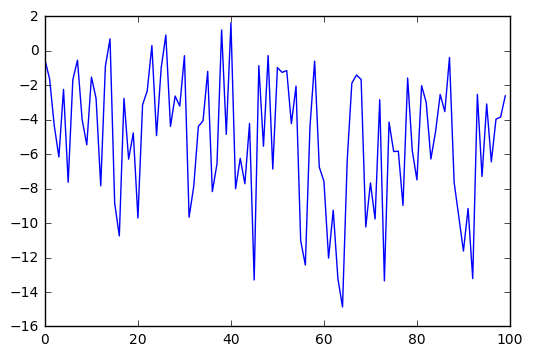

CPU times: user 8.67 s, sys: 601 ms, total: 9.27 s
Wall time: 8.6 s


In [26]:
%%time
samples = [draw_informed_Mondrian(theta_space, table) for _ in range(100)]
log_p_priors = [comp_log_p_prior(sample, table, [1 for _ in range(theta_space.shape[0])]) for sample in samples]
plt.plot(log_p_priors)
plt.show()

## Flow Cytometry Data

Load AML dataset from [ACDC paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5447237/pdf/btx054.pdf)...

In [12]:
# load AML data and table
##### X: np.array, flow cytometry data, arcsin transformed
##### T: table of expert knowledge

np.random.seed(1234)
PATH = '/home/disij/projects/acdc/data/'

### LOAD DATA ###
path = PATH + 'AML_benchmark/'
df = pd.read_csv( path + 'AML_benchmark.csv.gz', sep=',', header = 0, compression = 'gzip', engine='python')
table = pd.read_csv(path + 'AML_table.csv', sep=',', header=0, index_col=0)
print table.shape

### PROCESS: discard ungated events ###
df = df[df.cell_type != 'NotGated']
df = df.drop(['Time', 'Cell_length','file_number', 'event_number', 'DNA1(Ir191)Di',
              'DNA2(Ir193)Di', 'Viability(Pt195)Di', 'subject'], axis = 1)
channels = [item[:item.find('(')] for item in df.columns[:-1]]
df.columns = channels + ['cell_type']
df = df.loc[df['cell_type'] != 'NotDebrisSinglets']

table = table.fillna(0)
X = df[channels].values
table_headers = list(table)
# df2 = pd.DataFrame([[0]*table.shape[1]], columns=table.columns, index =['unknown'])
# table = table.append(df2)

### transform data
data = np.arcsinh((X-1.)/5.)
theta_space = np.array([[data[:,d].min(), data[:,d].max()] for d in range(data.shape[1])])


cell_type_name2idx = {x:i for i,x in enumerate(table.index)}
Y = np.array([cell_type_name2idx[_] for _ in df.cell_type])

(14, 32)


In [13]:
print data.shape

(104184, 32)


## Experiment #0: Select pretty 2-D posteriors

In [114]:
print table.columns[2]
print table.columns[5]
print table.columns[6]
print table.columns[25]

CD19
CD4
CD8
CD3


In [168]:
%%time

data_2d = np.hstack([data[:,6][np.newaxis].T, data[:,25][np.newaxis].T])
np.random.shuffle(data_2d)
data_2d = data_2d[:1000,:]
print data_2d.shape

x_min, y_min, x_max, y_max = data_2d[:,0].min(), data_2d[:,1].min(), data_2d[:,0].max(), data_2d[:,1].max()
theta_space_2d = np.array([[x_min, x_max], [y_min, y_max]])
print theta_space_2d

table_2d = table[['CD8','CD3']]
print table_2d

n_mcmc_chain = 20
n_mcmc_sample = 1000
mcmc_gaussin_std = 0.1 # tune step size s.t. acceptance rate ~50%

accepts = [[] for _ in range(n_mcmc_chain)]
rejects = [[] for _ in range(n_mcmc_chain)]


for chain in range(n_mcmc_chain):
    
    if chain % 5 == 0:
        print "Drawing Chain %d ..." % chain
    
    sample = draw_informed_Mondrian(theta_space_2d, table_2d)
    log_p_sample = comp_log_p_sample(sample, data_2d) + \
                     comp_log_p_prior(sample, table_2d, [1 for _ in range(table_2d.shape[1])])
    
    accepts[chain].append(sample)
    
    for idx in xrange(n_mcmc_sample):
        
        new_sample = Mondrian_Gaussian_perturbation(theta_space_2d,sample, mcmc_gaussin_std)

        # perform accept-reject step
        new_log_p_sample = comp_log_p_sample(new_sample, data_2d) + \
                            comp_log_p_prior(new_sample, table_2d, [1 for _ in range(table_2d.shape[1])])
        
        if new_log_p_sample <  log_p_sample and \
            np.log(np.random.uniform(low=0, high=1.)) > new_log_p_sample - log_p_sample:
                rejects[chain].append(new_sample)
        
        else:
            sample = new_sample
            log_p_sample = new_log_p_sample
            accepts[chain].append(sample)
        

        if (idx+1) % 10000 == 0 and (chain+1) % 1 == 0:
            print "Iteration %d, cummulative accepted sample size is %d" %(idx+1, len(accepts[chain]))

print "Total number of accepted samples: %d" %(sum([len(accepts[chain]) for chain in range(n_mcmc_chain)]))

(1000, 2)
[[-0.25357286  4.02151449]
 [-0.25133738  6.30255061]]
                        CD8  CD3
Basophils              -1.0   -1
CD4 T cells            -1.0    1
CD8 T cells             1.0    1
CD16- NK cells          0.0   -1
CD16+ NK cells          0.0   -1
CD34+CD38+CD123- HSPCs -1.0   -1
CD34+CD38+CD123+ HSPCs -1.0   -1
CD34+CD38lo HSCs       -1.0   -1
Mature B cells         -1.0   -1
Plasma B cells         -1.0   -1
Pre B cells            -1.0   -1
Pro B cells            -1.0   -1
Monocytes              -1.0   -1
pDCs                   -1.0   -1
Drawing Chain 0 ...
Drawing Chain 5 ...
Drawing Chain 10 ...
Drawing Chain 15 ...
Total number of accepted samples: 349
CPU times: user 1min 29s, sys: 57.3 ms, total: 1min 29s
Wall time: 1min 29s


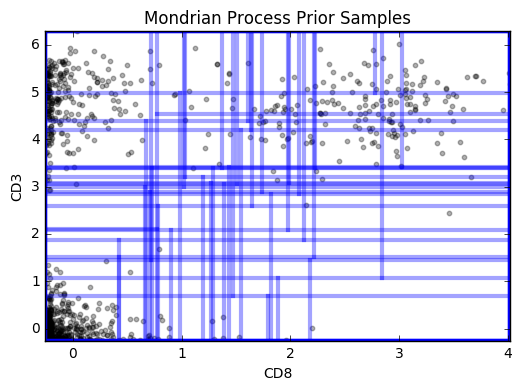

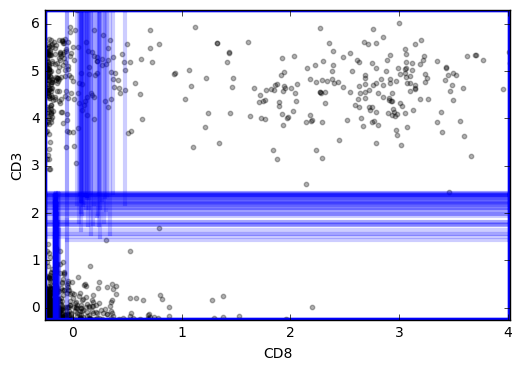

In [169]:
### VISUALIZE 2D MONDRIAN PROCESS ###
def print_partitions(p, trans_level=1., color='k'):
    if not p[1] and not p[2]: 
        plt.plot([p[0][0,0], p[0][0,0]], [p[0][1,0], p[0][1,1]], color+'-', linewidth=3, alpha=trans_level)
        plt.plot([p[0][0,1], p[0][0,1]], [p[0][1,0], p[0][1,1]], color+'-', linewidth=3, alpha=trans_level)
        plt.plot([p[0][0,0], p[0][0,1]], [p[0][1,0], p[0][1,0]], color+'-', linewidth=3, alpha=trans_level)
        plt.plot([p[0][0,0], p[0][0,1]], [p[0][1,1], p[0][1,1]], color+'-', linewidth=3, alpha=trans_level)
    
    else:
        print_partitions(p[1], trans_level, color)
        print_partitions(p[2], trans_level, color)
        
        
### VISUALIZE 2D POSTERIOR WITH DATA###
def print_posterior(data, samples, trans_level=.05, color='k'):

    plt.figure()
    plt.scatter(data[:,0], data[:,1], c='k', edgecolors='k', s=10, alpha=.2)

    #print all samples
    for sample in samples:
        print_partitions(sample, trans_level, color)
        
# print prior
burnt_accepts = [_ for chain in accepts for _ in chain[0:1]]
print_posterior(data_2d, burnt_accepts, trans_level=.2, color='b')

plt.xlabel("CD8")
plt.ylabel("CD3")
plt.title("Mondrian Process Prior Samples")

plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.show()


# print posterior
burnt_accepts = [_ for chain in accepts for _ in chain[-2:]]
print_posterior(data_2d, burnt_accepts, trans_level=.1, color='b')

plt.xlabel("CD8")
plt.ylabel("CD3")
#plt.title("Mondrian Process Posterior Samples")

plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.show()

In [170]:
%%time

data_2d = np.hstack([data[:,5][np.newaxis].T, data[:,25][np.newaxis].T])
np.random.shuffle(data_2d)
data_2d = data_2d[:1000,:]
print data_2d.shape

x_min, y_min, x_max, y_max = data_2d[:,0].min(), data_2d[:,1].min(), data_2d[:,0].max(), data_2d[:,1].max()
theta_space_2d = np.array([[x_min, x_max], [y_min, y_max]])
print theta_space_2d

table_2d = table[['CD4','CD3']]
print table_2d

n_mcmc_chain = 20
n_mcmc_sample = 1000
mcmc_gaussin_std = 0.1 # tune step size s.t. acceptance rate ~50%

accepts = [[] for _ in range(n_mcmc_chain)]
rejects = [[] for _ in range(n_mcmc_chain)]


for chain in range(n_mcmc_chain):
    
    if chain % 5 == 0:
        print "Drawing Chain %d ..." % chain
    
    sample = draw_informed_Mondrian(theta_space_2d, table_2d)
    log_p_sample = comp_log_p_sample(sample, data_2d) + \
                     comp_log_p_prior(sample, table_2d, [1 for _ in range(table_2d.shape[1])])
    
    accepts[chain].append(sample)
    
    for idx in xrange(n_mcmc_sample):
        
        new_sample = Mondrian_Gaussian_perturbation(theta_space_2d,sample, mcmc_gaussin_std)

        # perform accept-reject step
        new_log_p_sample = comp_log_p_sample(new_sample, data_2d) + \
                            comp_log_p_prior(new_sample, table_2d, [1 for _ in range(table_2d.shape[1])])
        
        if new_log_p_sample <  log_p_sample and \
            np.log(np.random.uniform(low=0, high=1.)) > new_log_p_sample - log_p_sample:
                rejects[chain].append(new_sample)
        
        else:
            sample = new_sample
            log_p_sample = new_log_p_sample
            accepts[chain].append(sample)
        

        if (idx+1) % 10000 == 0 and (chain+1) % 1 == 0:
            print "Iteration %d, cummulative accepted sample size is %d" %(idx+1, len(accepts[chain]))

print "Total number of accepted samples: %d" %(sum([len(accepts[chain]) for chain in range(n_mcmc_chain)]))


(1000, 2)
[[-0.25220035  2.59079537]
 [-0.25331798  6.15497694]]
                        CD4  CD3
Basophils               0.0   -1
CD4 T cells             1.0    1
CD8 T cells            -1.0    1
CD16- NK cells          0.0   -1
CD16+ NK cells          0.0   -1
CD34+CD38+CD123- HSPCs  0.0   -1
CD34+CD38+CD123+ HSPCs  0.0   -1
CD34+CD38lo HSCs        0.0   -1
Mature B cells          0.0   -1
Plasma B cells          0.0   -1
Pre B cells             0.0   -1
Pro B cells             0.0   -1
Monocytes               0.0   -1
pDCs                    0.0   -1
Drawing Chain 0 ...
Drawing Chain 5 ...
Drawing Chain 10 ...
Drawing Chain 15 ...
Total number of accepted samples: 904
CPU times: user 1min 3s, sys: 138 ms, total: 1min 3s
Wall time: 1min 3s


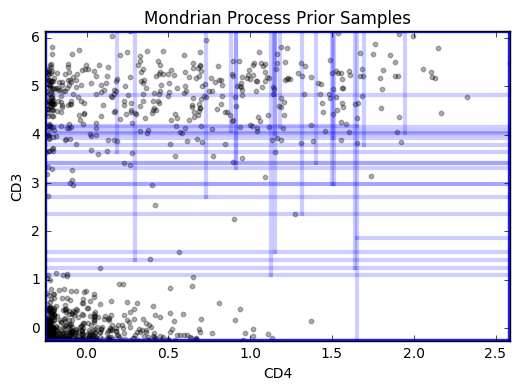

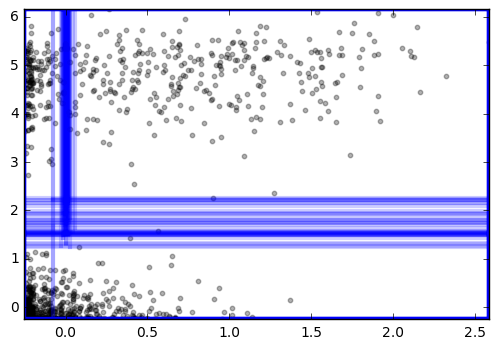

In [177]:
### VISUALIZE 2D MONDRIAN PROCESS ###
def print_partitions(p, trans_level=1., color='k'):
    if not p[1] and not p[2]: 
        plt.plot([p[0][0,0], p[0][0,0]], [p[0][1,0], p[0][1,1]], color+'-', linewidth=3, alpha=trans_level)
        plt.plot([p[0][0,1], p[0][0,1]], [p[0][1,0], p[0][1,1]], color+'-', linewidth=3, alpha=trans_level)
        plt.plot([p[0][0,0], p[0][0,1]], [p[0][1,0], p[0][1,0]], color+'-', linewidth=3, alpha=trans_level)
        plt.plot([p[0][0,0], p[0][0,1]], [p[0][1,1], p[0][1,1]], color+'-', linewidth=3, alpha=trans_level)
    
    else:
        print_partitions(p[1], trans_level, color)
        print_partitions(p[2], trans_level, color)
        
        
### VISUALIZE 2D POSTERIOR WITH DATA###
def print_posterior(data, samples, trans_level=.05, color='k'):

    plt.figure()
    plt.scatter(data[:,0], data[:,1], c='k', edgecolors='k', s=10, alpha=.3)

    #print all samples
    for sample in samples:
        print_partitions(sample, trans_level, color)

# print prior
burnt_accepts = [_ for chain in accepts for _ in chain[0:1]]
print_posterior(data_2d, burnt_accepts, trans_level=.1, color='b')

plt.xlabel("CD4")
plt.ylabel("CD3")
plt.title("Mondrian Process Prior Samples")

plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.show()


# print posterior
burnt_accepts = [_ for chain in accepts for _ in chain[-2:]]
print_posterior(data_2d, burnt_accepts, trans_level=.1, color='b')

# plt.xlabel("CD4")
# plt.ylabel("CD3")
#plt.title("Mondrian Process Posterior Samples")

plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.show()


## Experiment #1: 2D Simulation

Let's now test out the idea on a 2D subset of the data: the *CD4* and *CD8* features.

In [13]:
data_2d = np.hstack([data[:,5][np.newaxis].T, data[:,6][np.newaxis].T])
np.random.shuffle(data_2d)
data_2d = data_2d[:1000,:]
print data_2d.shape

x_min, y_min, x_max, y_max = data_2d[:,0].min(), data_2d[:,1].min(), data_2d[:,0].max(), data_2d[:,1].max()
theta_space_2d = np.array([[x_min, x_max], [y_min, y_max]])
print theta_space_2d

table_2d = table[['CD4','CD8']]

(1000, 2)
[[-0.2538249   2.81347347]
 [-0.2532051   4.047951  ]]


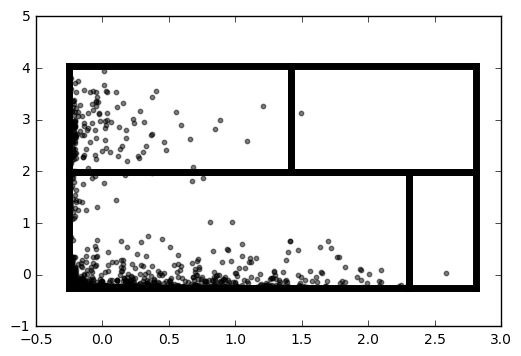

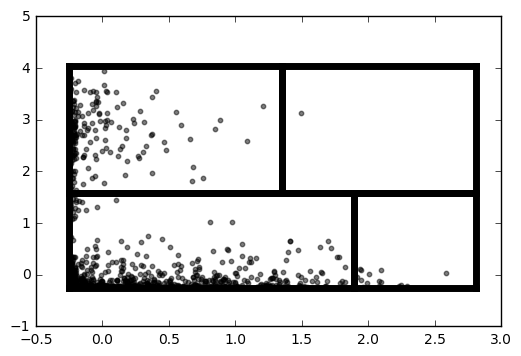

In [13]:
# test perturbation function
sample = draw_informed_Mondrian(theta_space_2d, table_2d)
plt.scatter(data_2d[:,0], data_2d[:,1], c='k', edgecolors='k', s=10, alpha=.5)
print_partitions(sample)
plt.show()


stepsize = 0.1
propose_sample = Mondrian_Gaussian_perturbation(theta_space_2d, sample, stepsize)

plt.scatter(data_2d[:,0], data_2d[:,1], c='k', edgecolors='k', s=10, alpha=.5)
print_partitions(propose_sample)
plt.show()

Now run MCMC to collect posterior samples...

In [16]:
%%time

n_mcmc_chain = 5
n_mcmc_sample = 10000
mcmc_gaussin_std = 0.005 # tune step size s.t. acceptance rate ~50%

accepts = [[] for _ in range(n_mcmc_chain)]
rejects = [[] for _ in range(n_mcmc_chain)]


for chain in range(n_mcmc_chain):
    
    if chain % 5 == 0:
        print "Drawing Chain %d ..." % chain
    
    sample = draw_informed_Mondrian(theta_space_2d, table_2d)
    log_p_sample = comp_log_p_sample(sample, data_2d) + \
                     comp_log_p_prior(sample, table_2d, [1 for _ in range(table_2d.shape[1])])
    
    accepts[chain].append(sample)
    
    for idx in xrange(n_mcmc_sample):
        
        new_sample = Mondrian_Gaussian_perturbation(theta_space_2d,sample, mcmc_gaussin_std)

        # perform accept-reject step
        new_log_p_sample = comp_log_p_sample(new_sample, data_2d) + \
                            comp_log_p_prior(new_sample, table_2d, [1 for _ in range(table_2d.shape[1])])
        
        if new_log_p_sample <  log_p_sample and \
            np.log(np.random.uniform(low=0, high=1.)) > new_log_p_sample - log_p_sample:
                rejects[chain].append(new_sample)
        
        else:
            sample = new_sample
            log_p_sample = new_log_p_sample
            accepts[chain].append(sample)
        

        if (idx+1) % 10000 == 0 and (chain+1) % 1 == 0:
            print "Iteration %d, cummulative accepted sample size is %d" %(idx+1, len(accepts[chain]))

print "Total number of accepted samples: %d" %(sum([len(accepts[chain]) for chain in range(n_mcmc_chain)]))

Drawing Chain 0 ...
Iteration 10000, cummulative accepted sample size is 2025
Total number of accepted samples: 10068
CPU times: user 6min 48s, sys: 1.08 s, total: 6min 49s
Wall time: 6min 49s


In [17]:
# get an average model
burnt_accepts = np.array([_ for chain in accepts for _ in chain[len(chain)*10/11:]])

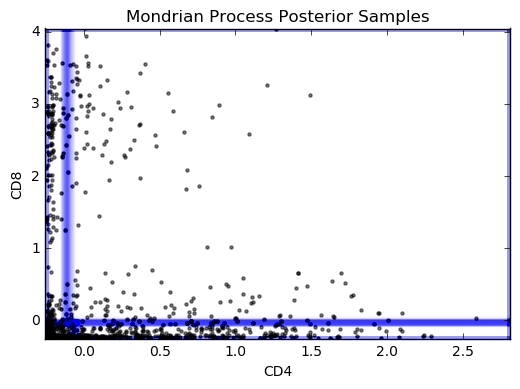

In [18]:
#### plt.figure()

np.random.shuffle(burnt_accepts)
print_posterior(data_2d, burnt_accepts[:100], trans_level=.005, color='b')

plt.xlabel("CD4")
plt.ylabel("CD8")
plt.title("Mondrian Process Posterior Samples")

plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.show()

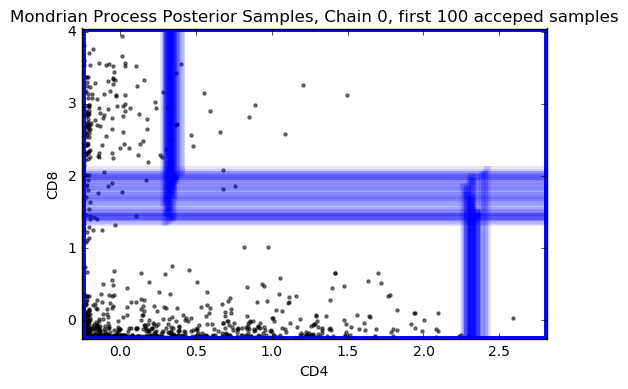

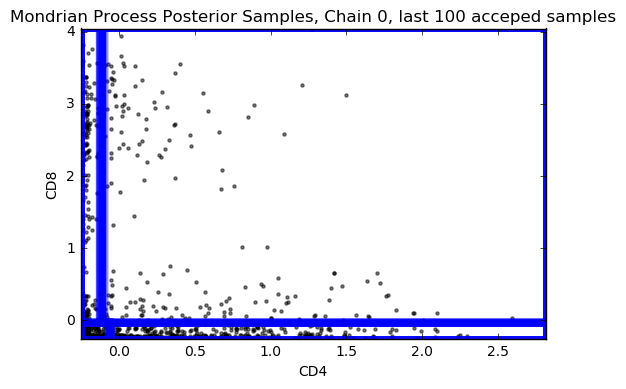

In [19]:
#### plt.figure()


print_posterior(data_2d, accepts[0][:50], trans_level=.05, color='b')

plt.xlabel("CD4")
plt.ylabel("CD8")
plt.title("Mondrian Process Posterior Samples, Chain 0, first 100 acceped samples")

plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.show()



print_posterior(data_2d, accepts[0][-50:], trans_level=.05, color='b')

plt.xlabel("CD4")
plt.ylabel("CD8")
plt.title("Mondrian Process Posterior Samples, Chain 0, last 100 acceped samples")

plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.show()

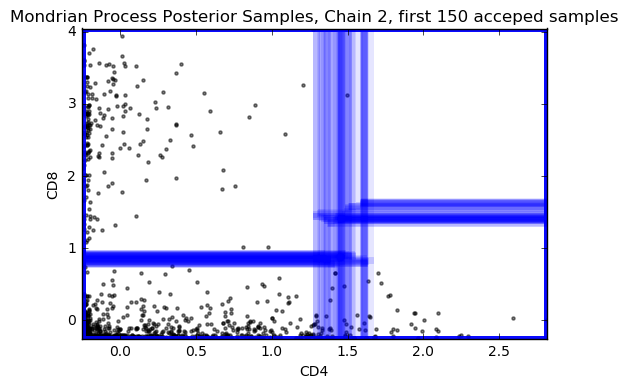

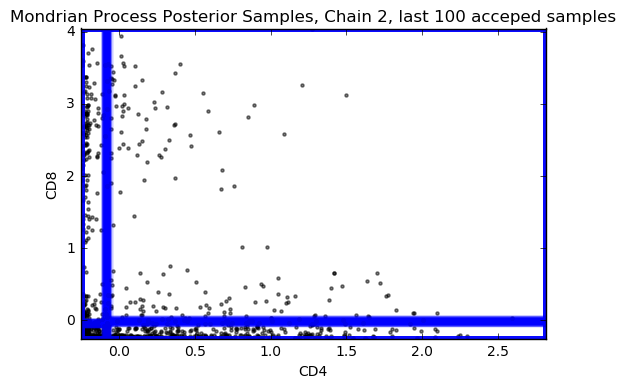

In [20]:
#### plt.figure()

print_posterior(data_2d, accepts[1][:50], trans_level=.05, color='b')

plt.xlabel("CD4")
plt.ylabel("CD8")
plt.title("Mondrian Process Posterior Samples, Chain 2, first 150 acceped samples")

plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.show()


print_posterior(data_2d, accepts[1][-50:], trans_level=.05, color='b')

plt.xlabel("CD4")
plt.ylabel("CD8")
plt.title("Mondrian Process Posterior Samples, Chain 2, last 100 acceped samples")

plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.show()

## Experiment #2: subset AML data, 3 chains  

In [ ]:
from sklearn.utils import shuffle

# N = data.shape[0] 
# new_df = shuffle(df)[:N]
# X_subset = new_df[channels].values
# Y_subset = np.array([cell_type_name2idx[_] for _ in new_df.cell_type])
X_subset = df[channels].values
Y_subset = np.array([cell_type_name2idx[_] for _ in df.cell_type])
data_subset = np.arcsinh((X_subset-1.)/5.)
N, d = data_subset.shape
print N,d

# rename table header 'HLA-DR' to 'HLADR' to prevent error from '-'
temp_headers = list(table)
temp_headers[29] = "HLADR"
table.columns = temp_headers
print table.columns

emp_bounds = np.array([(data_subset[:,i].min(), data_subset[:,i].max()) for i in range(d)])

104184 32
Index([u'CD45RA', u'CD133', u'CD19', u'CD22', u'CD11b', u'CD4', u'CD8',
       u'CD34', u'Flt3', u'CD20', u'CXCR4', u'CD235ab', u'CD45', u'CD123',
       u'CD321', u'CD14', u'CD33', u'CD47', u'CD11c', u'CD7', u'CD15', u'CD16',
       u'CD44', u'CD38', u'CD13', u'CD3', u'CD61', u'CD117', u'CD49d',
       u'HLADR', u'CD64', u'CD41'],
      dtype='object')


In [ ]:
%%time

n_mcmc_chain = 20
n_mcmc_sample = 5000
mcmc_gaussin_std = 0.1 # tune step size s.t. acceptance rate ~50%

accepts = [[] for _ in range(n_mcmc_chain)]
rejects = [[] for _ in range(n_mcmc_chain)]
logl_accepted_trace = [[] for _ in range(n_mcmc_chain)]
logl_complete_trace = [[] for _ in range(n_mcmc_chain)]
Y_predict_accepted_trace = [[] for _ in range(n_mcmc_chain)]
accuracy_accepted_trace = [[] for _ in range(n_mcmc_chain)]


for chain in range(n_mcmc_chain):
    
    print "Drawing Chain %d ..." % chain
    
    sample = draw_informed_Mondrian(emp_bounds, table)
    log_p_sample = comp_log_p_sample(sample, data_subset)
    
    accepts[chain].append(sample)
    logl_accepted_trace[chain].append(log_p_sample)
    logl_complete_trace[chain].append(log_p_sample)

    
    Y_predict = classify_cells(data_subset, sample, table, cell_type_name2idx)
    accuracy = sum(Y_subset == Y_predict)*1.0/ data_subset.shape[0]
    accuracy_accepted_trace[chain].append(accuracy)
    Y_predict_accepted_trace[chain].append(Y_predict)
    
    for idx in range(n_mcmc_sample):
        
        new_sample = Mondrian_Gaussian_perturbation(emp_bounds,sample, mcmc_gaussin_std)
        new_log_p_sample = comp_log_p_sample(new_sample, data_subset) 
        logl_complete_trace[chain].append(new_log_p_sample)
        
        if new_log_p_sample <  log_p_sample and \
            np.log(np.random.uniform(low=0, high=1.)) > (new_log_p_sample - log_p_sample):
                rejects[chain].append(new_sample)
        
        else:
            if new_log_p_sample <  log_p_sample:
                print "accepted some bad samples"
                
            sample = new_sample
            log_p_sample = new_log_p_sample
            accepts[chain].append(sample)
            logl_accepted_trace[chain].append(log_p_sample)
        
            Y_predict = classify_cells(data_subset, sample, table, cell_type_name2idx)
            accuracy = sum(Y_subset == Y_predict)*1.0/ data_subset.shape[0]
            accuracy_accepted_trace[chain].append(accuracy)
            Y_predict_accepted_trace[chain].append(Y_predict)
        
        if (idx+1) % 500 == 0:
            print "Iteration %d, cummulative accepted sample size is %d" %(idx+1, len(accepts[chain]))
            
    
    if (chain + 1) % 10 == 0:
        # prediction and visualization
        Y_predict = classify_cells(data_subset, accepts[chain][-1], table, cell_type_name2idx)
        accuracy = sum(Y_subset == Y_predict)*1.0/ data_subset.shape[0]
        print "Chain % d accuracy on subset data: %.3f" % (chain+1,accuracy)

            
print "Total number of accepted samples: %d" %(sum([len(accepts[chain]) for chain in range(n_mcmc_chain)]))
# 3 chain, 5000 samples

Drawing Chain 0 ...
Iteration 500, cummulative accepted sample size is 17
Iteration 1000, cummulative accepted sample size is 18


### Visualize hierarchical histograms

In [ ]:
# generte tree structures for visualization
def find_cuts(list_of_mp_trees):
    if len(list_of_mp_trees) == 0:
        return None
    mp_tree = list_of_mp_trees[0]
    if mp_tree[1] == None and mp_tree[2] == None: 
        return None
    
    # find the dimension and location of first cut
    root_rec = mp_tree[0]
    left_rec = mp_tree[1][0]
    
    for _ in range(root_rec.shape[0]):
        if root_rec[_,1] != left_rec[_,1]:
            break
    d, pos = _, left_rec[_,1]
    
    first_cut = [d]+[mp_tree[1][0][d,1] for mp_tree in list_of_mp_trees]
    
    list_of_left_mp_trees = [mp_tree[1] for mp_tree in list_of_mp_trees]
    list_of_right_mp_trees = [mp_tree[2] for mp_tree in list_of_mp_trees]
    
    return [first_cut, find_cuts(list_of_left_mp_trees),find_cuts(list_of_right_mp_trees)]

def split_data_by_MP(mp_tree, data):
    if mp_tree[1] == None and mp_tree[2] == None:
        return [data,None, None]
    
    # find the dimension and location of first cut
    root_rec = mp_tree[0]
    left_rec = mp_tree[1][0]
    
    for _ in range(root_rec.shape[0]):
        if root_rec[_,1] != left_rec[_,1]:
            break
    d, pos = _, left_rec[_,1]    
    
    data_left = data[data[:,d] < pos]
    data_right = data[data[:,d] >= pos]
    
    return [data,split_data_by_MP(mp_tree[1], data_left),split_data_by_MP(mp_tree[2], data_right)]
    
def print_cuts_on_hist(tree_tructured_data, theta_space_cuts, node_pos, table):
    depth = len(node_pos)
    cuts = theta_space_cuts
    data_leaf = tree_tructured_data
    for _ in node_pos:
        _ = int(_)
        data_leaf = data_leaf[_]

    for _ in node_pos:
        _ = int(_)
        cuts = cuts[_]
        if cuts == None:
            print "leaf node"
            print "size of cell type:,", data_leaf.shape
            return
        
    dim = cuts[0]
    list_pos = cuts[1:]
    
    print data_leaf.shape
    
    # plot histogram    
    n, b, patches = plt.hist(data_leaf[:,dim], bins=100, alpha=0.5, label=table.columns[dim])
    plt.legend(loc='upper right',prop={'size': 40})
    
    plt.yscale('log')
    
    # plot cuts
    for pos in list_pos:
        plt.plot([pos,pos],[0,n.max()],color='r',linewidth = 3,alpha= 0.5)
    plt.show()
    return

(104184, 32)


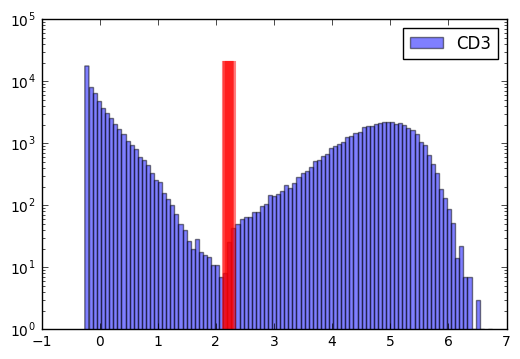

(57711, 32)


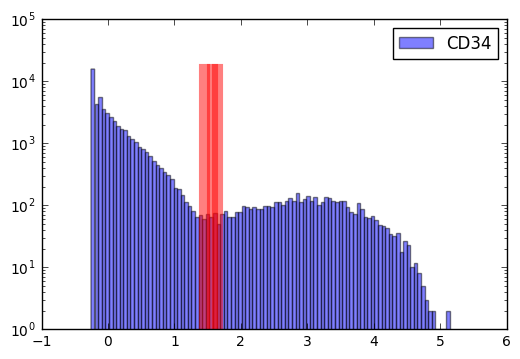

(46473, 32)


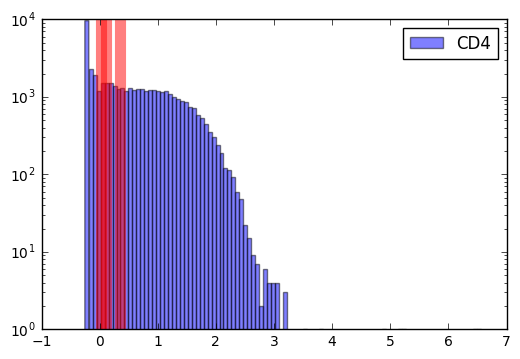

(52802, 32)


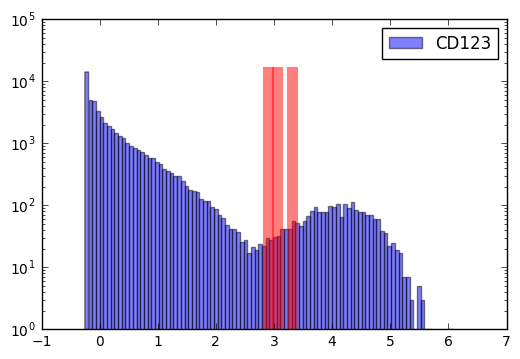

(4909, 32)


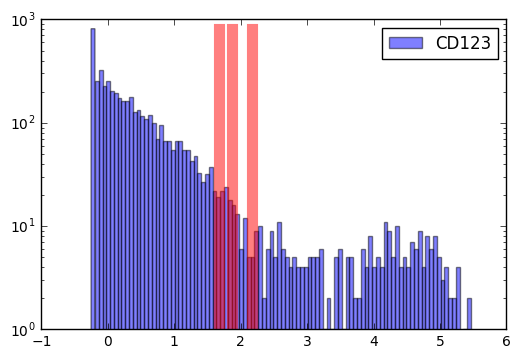

(50596, 32)


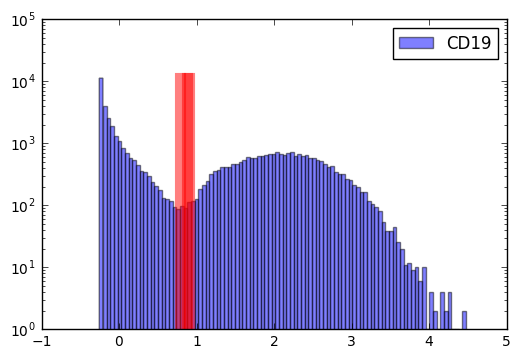

(2206, 32)


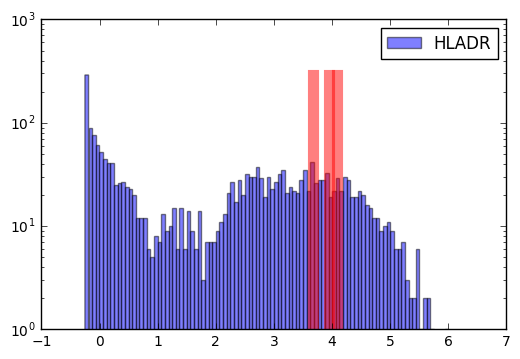

(4496, 32)


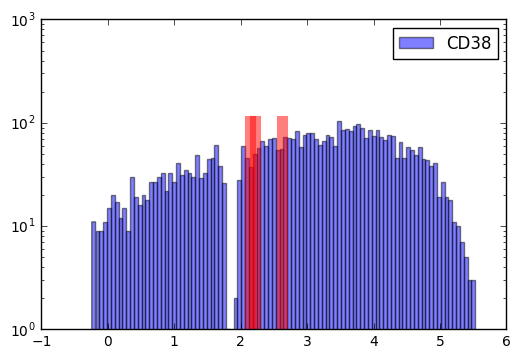

(27691, 32)


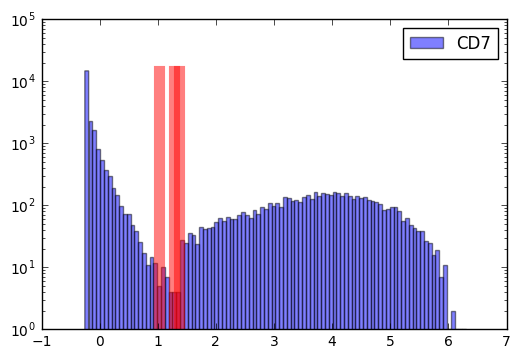

(22905, 32)


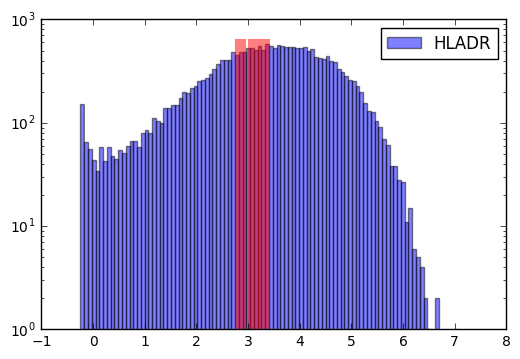

(2934, 32)


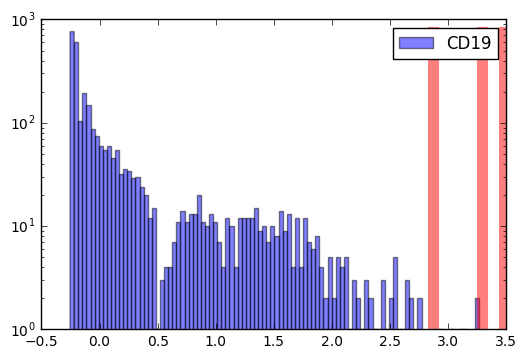

(6151, 32)


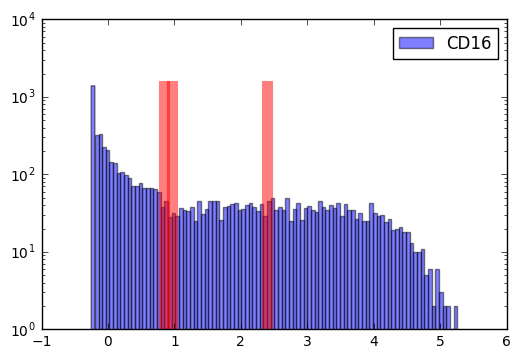

(10502, 32)


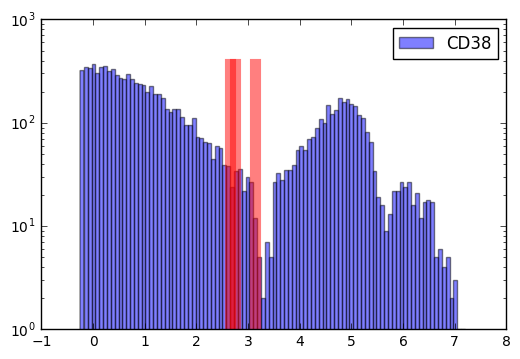

(12403, 32)


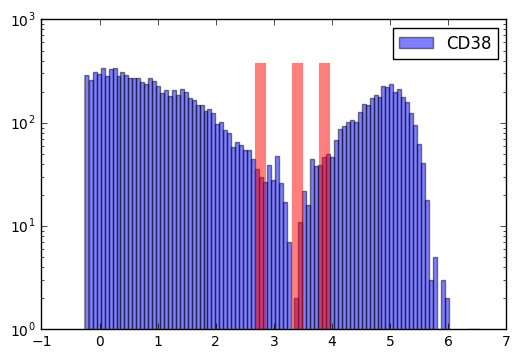

In [48]:
max_logl_chains =  [sum(_[-1:]) for _ in logl_accepted_trace]
optimal_chain = accepts[max_logl_chains.index(max(max_logl_chains))][-3:]

optimal_chain = accepts[2][-3:]
theta_space_cuts = find_cuts(optimal_chain)
#'0','10','20','110','120','1110','1120','1210','11110','11120','12120','111120','111210','111220'
node_pos_list = ['0','10','20','110','120','1110','1120','1210','11110',\
                 '11120','12120','111120','111210','111220']
tree_tructured_data = split_data_by_MP(optimal_chain[-1], data_subset)
for node_pos in node_pos_list:
    print_cuts_on_hist(tree_tructured_data,theta_space_cuts,node_pos,table)

In [57]:
%%time

n_mcmc_chain = 1
n_mcmc_sample = 10000
mcmc_gaussin_std = 0.01 # tune step size s.t. acceptance rate ~50%

accepts_append = [[] for _ in range(n_mcmc_chain)]
rejects_append = [[] for _ in range(n_mcmc_chain)]

for chain in range(n_mcmc_chain):
    
    sample = accepts[2][-1]
    log_p_sample = comp_log_p_sample(sample, data_subset)
    
    for idx in range(n_mcmc_sample):
        
        new_sample = Mondrian_Gaussian_perturbation(emp_bounds,sample, mcmc_gaussin_std)
        new_log_p_sample = comp_log_p_sample(new_sample, data_subset) 
        logl_complete_trace[chain].append(new_log_p_sample)
        
        if new_log_p_sample <  log_p_sample and \
            np.log(np.random.uniform(low=0, high=1.)) > (new_log_p_sample - log_p_sample):
                rejects_append[chain].append(new_sample)
        
        else:
            if new_log_p_sample <  log_p_sample:
                print "accepted some bad samples"
                
            sample = new_sample
            log_p_sample = new_log_p_sample
            accepts_append[chain].append(sample)
        
        if (idx+1) % 500 == 0:
            print "Iteration %d, cummulative accepted sample size is %d" %(idx+1, len(accepts_append[chain]))
                        
print "Total number of accepted samples: %d" %(sum([len(accepts[chain]) for chain in range(n_mcmc_chain)]))
# 3 chain, 5000 samples

Iteration 500, cummulative accepted sample size is 15
Iteration 1000, cummulative accepted sample size is 15
Iteration 1500, cummulative accepted sample size is 15
Iteration 2000, cummulative accepted sample size is 15
Iteration 2500, cummulative accepted sample size is 15
Iteration 3000, cummulative accepted sample size is 15
Iteration 3500, cummulative accepted sample size is 15
Iteration 4000, cummulative accepted sample size is 15
Iteration 4500, cummulative accepted sample size is 15
Iteration 5000, cummulative accepted sample size is 15
Iteration 5500, cummulative accepted sample size is 15
Iteration 6000, cummulative accepted sample size is 15
Iteration 6500, cummulative accepted sample size is 15
Iteration 7000, cummulative accepted sample size is 15
Iteration 7500, cummulative accepted sample size is 15
Iteration 8000, cummulative accepted sample size is 15
Iteration 8500, cummulative accepted sample size is 15
Iteration 9000, cummulative accepted sample size is 15
Iteration 9

(104184, 32)


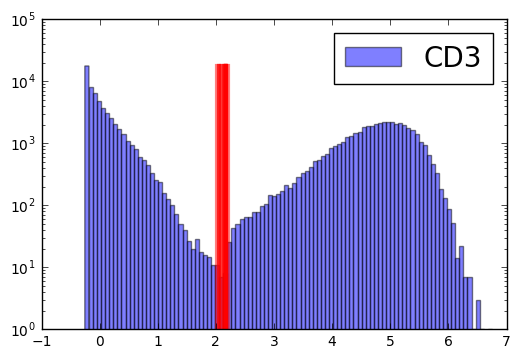

(57700, 32)


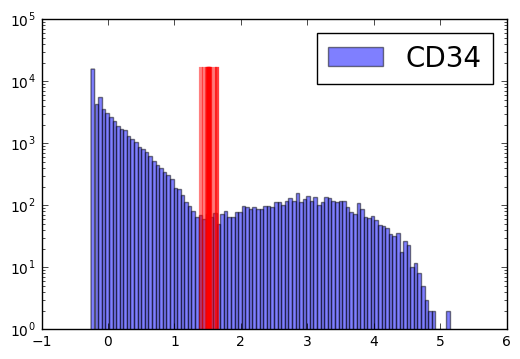

(46484, 32)


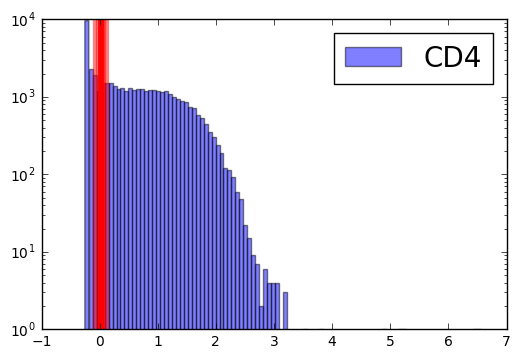

(52712, 32)


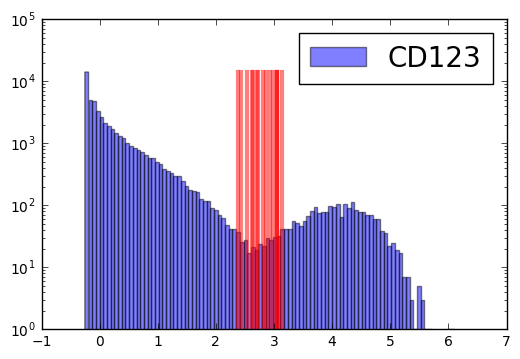

(4988, 32)


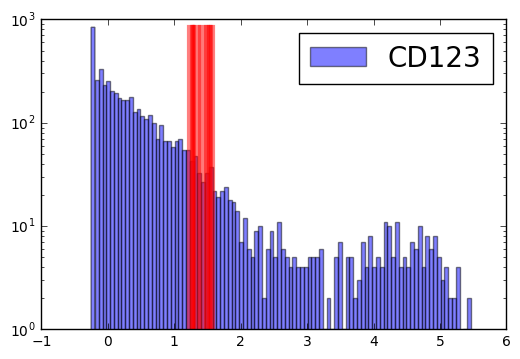

(50252, 32)


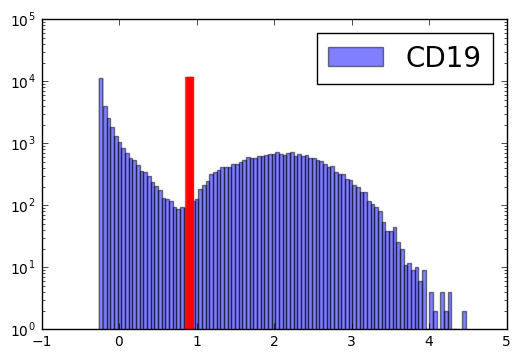

(2460, 32)


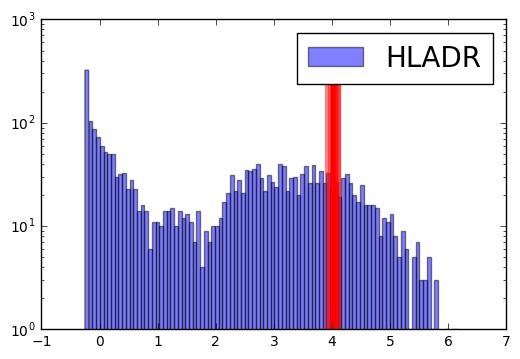

(4340, 32)


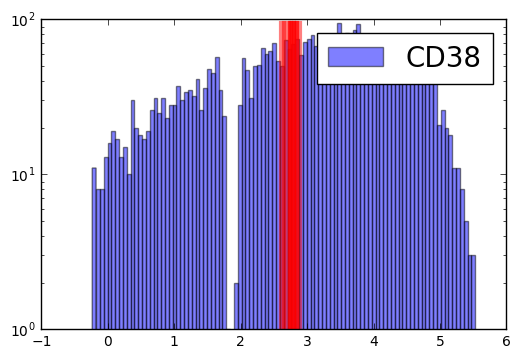

(27444, 32)


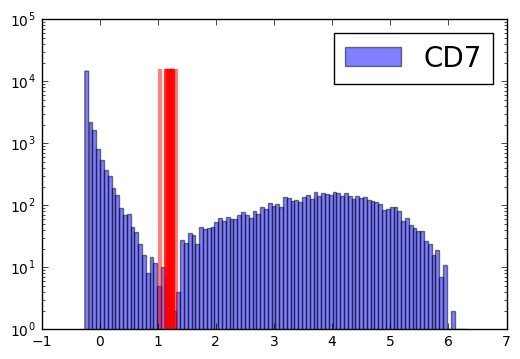

(22808, 32)


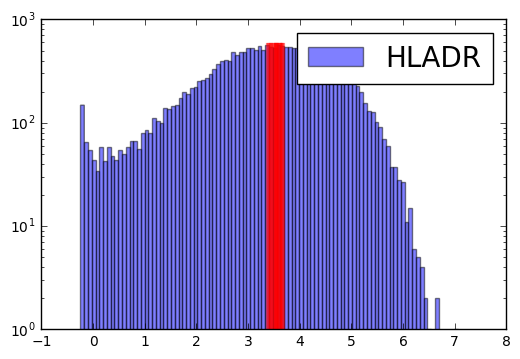

(2702, 32)


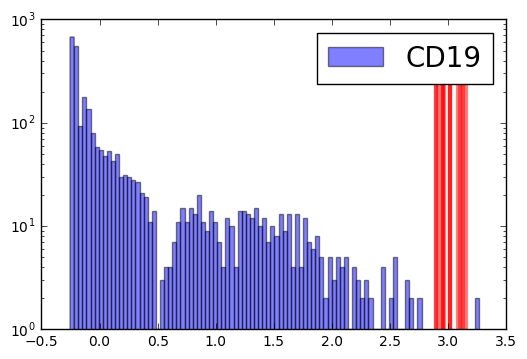

(6119, 32)


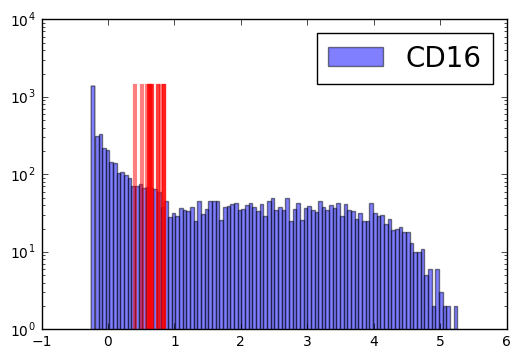

(11626, 32)


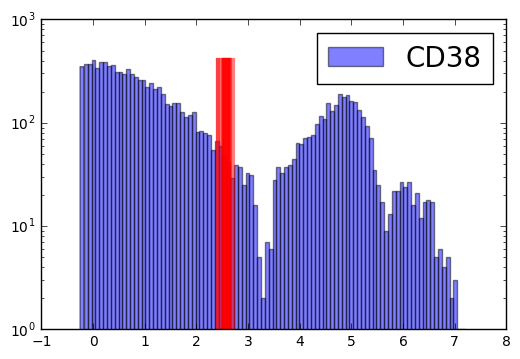

(11182, 32)


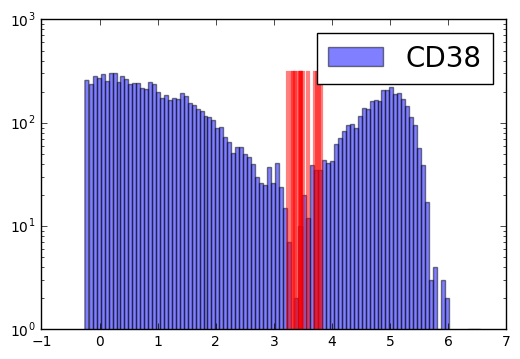

In [89]:
optimal_chain = accepts_append[0][-15:]
theta_space_cuts = find_cuts(optimal_chain)
#'0','10','20','110','120','1110','1120','1210','11110','11120','12120','111120','111210','111220'
node_pos_list = ['0','10','20','110','120','1110','1120','1210','11110',\
                 '11120','12120','111120','111210','111220']
tree_tructured_data = split_data_by_MP(optimal_chain[-1], data_subset)
for node_pos in node_pos_list:
    print_cuts_on_hist(tree_tructured_data,theta_space_cuts,node_pos,table)

In [71]:
node_pos_list = ['210','220','1220','11210','11220','12110','111110',\
                 '121210','121220','1111210','1111220','1112110','1112120',\
                 '1112210','1112220']
tree_tructured_data = split_data_by_MP(optimal_chain[-1], data_subset)
for node_pos in node_pos_list:
    print_cuts_on_hist(tree_tructured_data,theta_space_cuts,node_pos,table)

leaf node
size of cell type:, (15327, 32)
leaf node
size of cell type:, (31157, 32)
leaf node
size of cell type:, (648, 32)
leaf node
size of cell type:, (2076, 32)
leaf node
size of cell type:, (384, 32)
leaf node
size of cell type:, (1638, 32)
leaf node
size of cell type:, (21325, 32)
leaf node
size of cell type:, (2698, 32)
leaf node
size of cell type:, (4, 32)
leaf node
size of cell type:, (3199, 32)
leaf node
size of cell type:, (2920, 32)
leaf node
size of cell type:, (8441, 32)
leaf node
size of cell type:, (3185, 32)
leaf node
size of cell type:, (7848, 32)
leaf node
size of cell type:, (3334, 32)


In [95]:
def query_table(table,list_of_condition):
    if len(list_of_condition) == 0:
        return table
    
    dim, label = list_of_condition[0]
    if label == 1:
        table = table[table[dim] >= 0]
    else:
        table = table[table[dim] <= 0]
        
    return query_table(table, list_of_condition[1:])

conditions  = [['CD3',1],['CD4', -1]]
print query_table(table, conditions).index
conditions  = [['CD3',1],['CD4', 1]]
print query_table(table, conditions).index
conditions  = [['CD3',-1],['CD34', 1],['CD123',1]]
print query_table(table, conditions).index
conditions  = [['CD3',-1],['CD34', -1],['CD123',1],['HLADR',-1]]
print query_table(table, conditions).index
conditions  = [['CD3',-1],['CD34', -1],['CD123',1],['HLADR',1]]
print query_table(table, conditions).index
conditions  = [['CD3',-1],['CD34', 1],['CD123',-1],['CD38',-1]]
print query_table(table, conditions).index
conditions = [['CD3',-1],['CD34',-1],['CD123',-1],['CD19',-1],['CD7',-1]]
print query_table(table, conditions).index
conditions  = [['CD3',-1],['CD34', 1],['CD123',-1],['CD38',1],['CD19',-1]]
print query_table(table, conditions).index
conditions  = [['CD3',-1],['CD34', 1],['CD123',-1],['CD38',1],['CD19',1]]
print query_table(table, conditions).index
conditions = [['CD3',-1],['CD34',-1],['CD123',-1],['CD19',-1],['CD7',1],['CD16',-1]]
print query_table(table, conditions).index
conditions = [['CD3',-1],['CD34',-1],['CD123',-1],['CD19',-1],['CD7',1],['CD16',-1]]
print query_table(table, conditions).index
conditions  = [['CD3',-1],['CD34',-1],['CD123',-1],['CD19',1],['HLADR',-1],['CD38',-1]]
print query_table(table, conditions).index
conditions  = [['CD3',-1],['CD34',-1],['CD123',-1],['CD19',1],['HLADR',-1],['CD38',1]]
print query_table(table, conditions).index
conditions  = [['CD3',-1],['CD34',-1],['CD123',-1],['CD19',1],['HLADR',1],['CD38',-1]]
print query_table(table, conditions).index
conditions  = [['CD3',-1],['CD34',-1],['CD123',-1],['CD19',1],['HLADR',1],['CD38',1]]
print query_table(table, conditions).index


print table.loc['CD34+CD38+CD123+ HSPCs']
print table

Index([u'CD8 T cells'], dtype='object')
Index([u'CD4 T cells'], dtype='object')
Index([u'CD34+CD38+CD123+ HSPCs'], dtype='object')
Index([u'Basophils'], dtype='object')
Index([u'pDCs'], dtype='object')
Index([u'CD34+CD38lo HSCs'], dtype='object')
Index([u'Monocytes'], dtype='object')
Index([u'CD34+CD38+CD123- HSPCs'], dtype='object')
Index([u'Pro B cells'], dtype='object')
Index([u'CD16- NK cells'], dtype='object')
Index([u'CD16- NK cells'], dtype='object')
Index([u'Mature B cells'], dtype='object')
Index([u'Mature B cells', u'Plasma B cells'], dtype='object')
Index([u'Mature B cells'], dtype='object')
Index([u'Mature B cells', u'Pre B cells'], dtype='object')
CD45RA     0.0
CD133      0.0
CD19      -1.0
CD22       0.0
CD11b      0.0
CD4        0.0
CD8       -1.0
CD34       1.0
Flt3       0.0
CD20      -1.0
CXCR4      0.0
CD235ab    0.0
CD45      -1.0
CD123      1.0
CD321      0.0
CD14       0.0
CD33       0.0
CD47       0.0
CD11c     -1.0
CD7       -1.0
CD15       0.0
CD16      -1.0
C

In [93]:
cell_type_name2idx['Pro B cells']
len(Y[Y == 11]) * 1.0 / len(Y)

0.0049239806496199036

Accuracy on data: 0.874


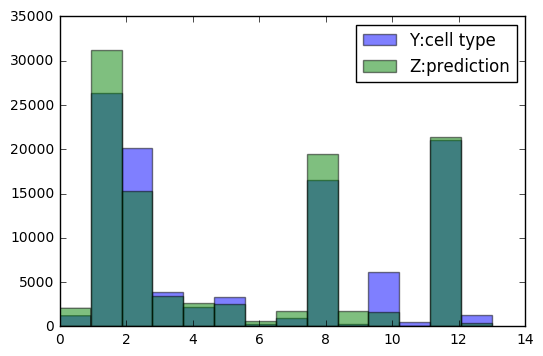

In [103]:
Y_predict = classify_cells(data, accepts_append[0][-3], table, cell_type_name2idx)
accuracy = sum(Y == Y_predict)*1.0/ data.shape[0]
print "Accuracy on data: %.3f" % accuracy

bins = table.shape[0]
plt.hist(Y, bins, alpha=0.5, label='Y:cell type')
plt.hist(Y_predict, bins, alpha=0.5, label='Z:prediction')
plt.legend(loc='upper right')
plt.show() 

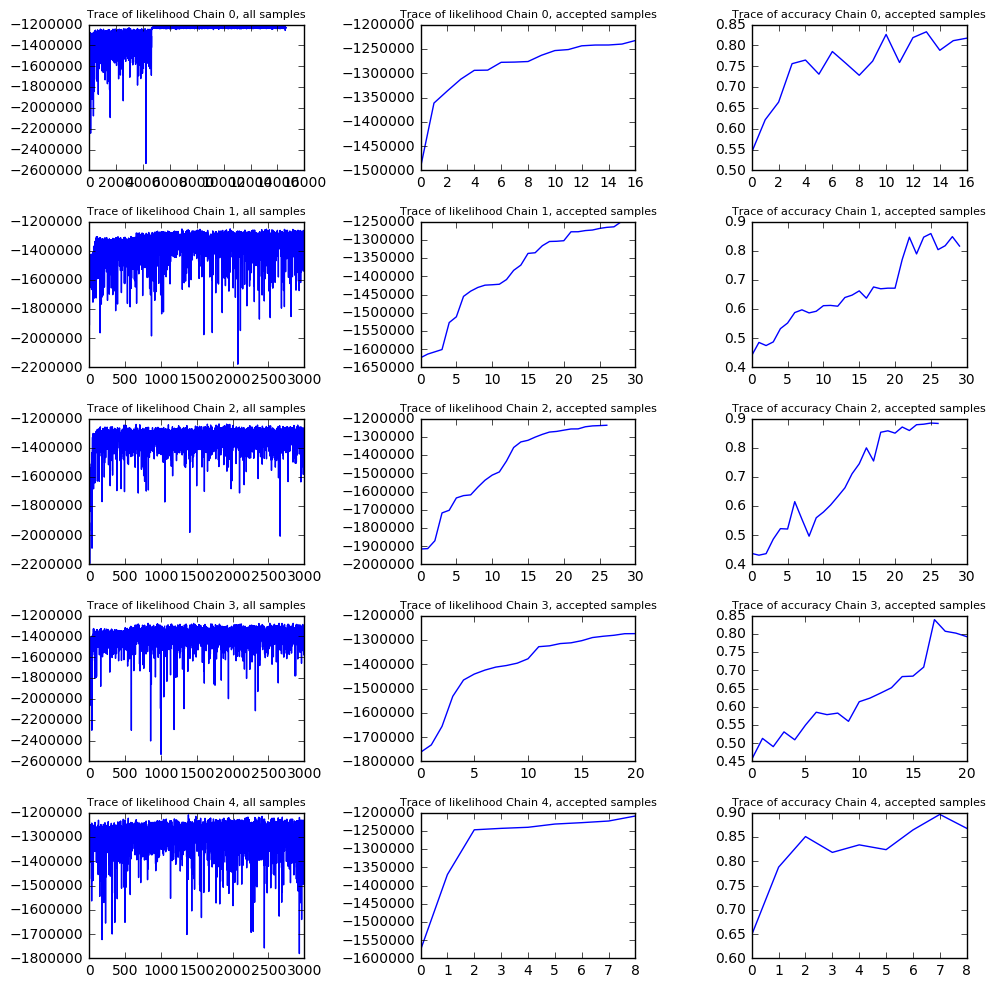

In [63]:
# plot 5 chains

threshold = -113888.425449/data.shape[0]*N
fig, axs = plt.subplots(5, 3, figsize=(10,10) )
for chain in range(5):
    axs[chain, 0].plot(logl_complete_trace[chain])
    axs[chain, 1].plot(logl_accepted_trace[chain])
    axs[chain, 2].plot(accuracy_accepted_trace[chain])
    axs[chain, 0].set_title('Trace of likelihood Chain %d, all samples' % chain, fontsize=8)
    axs[chain, 1].set_title('Trace of likelihood Chain %d, accepted samples' % chain, fontsize=8)
    axs[chain, 2].set_title('Trace of accuracy Chain %d, accepted samples' % chain, fontsize=8)
    
fig.tight_layout()

50
Total number of accepted samples: 17
(104184, 32)


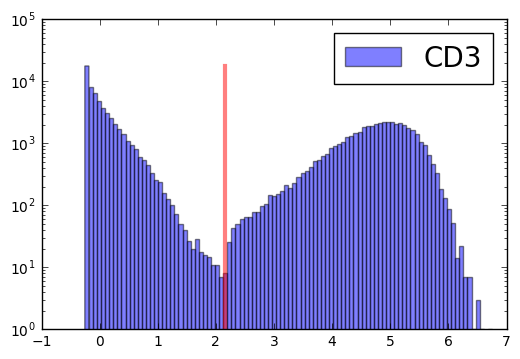

(57699, 32)


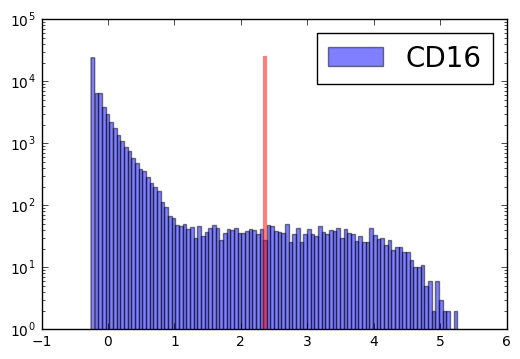

(46485, 32)


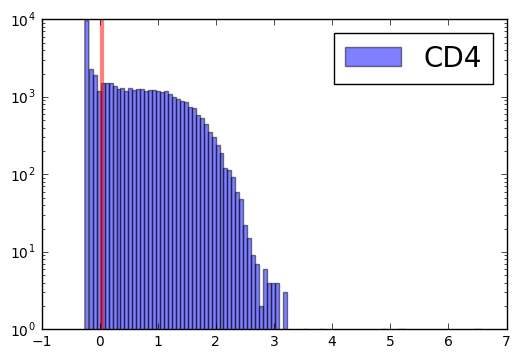

In [143]:
print len(accepts)
n_mcmc_chain = 1
n_mcmc_sample = 10000
mcmc_gaussin_std = 0.01 # tune step size s.t. acceptance rate ~50%

accepts_temp = [[] for _ in range(n_mcmc_chain)]
rejects_temp = [[] for _ in range(n_mcmc_chain)]

for chain in range(n_mcmc_chain):
    
    sample = accepts[28][-1]
    log_p_sample = comp_log_p_sample(sample, data_subset)
    accepts_temp[chain].append(sample)
    
    for idx in range(n_mcmc_sample):
        
        new_sample = Mondrian_Gaussian_perturbation(emp_bounds,sample, mcmc_gaussin_std)
        new_log_p_sample = comp_log_p_sample(new_sample, data_subset) 
        logl_complete_trace[chain].append(new_log_p_sample)
        
        if new_log_p_sample <  log_p_sample and \
            np.log(np.random.uniform(low=0, high=1.)) > (new_log_p_sample - log_p_sample):
                rejects_temp[chain].append(new_sample)
        
        else:
            if new_log_p_sample <  log_p_sample:
                print "accepted some bad samples"
                
            sample = new_sample
            log_p_sample = new_log_p_sample
            accepts_temp[chain].append(sample)
        
        if (idx+1) % 500 == 0:
            print "Iteration %d, cummulative accepted sample size is %d" %(idx+1, len(accepts_append[chain]))
                        
print "Total number of accepted samples: %d" %(sum([len(accepts[chain]) for chain in range(n_mcmc_chain)]))
# 3 chain, 5000 samples

optimal_chain = accepts_temp[0][-1:]
theta_space_cuts = find_cuts(optimal_chain)
#'0','10','20','110','120','1110','1120','1210','11110','11120','12120','111120','111210','111220'
node_pos_list = ['0','10','20']
tree_tructured_data = split_data_by_MP(optimal_chain[-1], data_subset)
for node_pos in node_pos_list:
    print_cuts_on_hist(tree_tructured_data,theta_space_cuts,node_pos,table)

In [53]:
subtable = table[table['CD3']<=0]
subtable = subtable[subtable['CD34']>=0]
subtable = subtable[subtable['CD123']<=0]
subtable = subtable[subtable['CD38']<=0]
subtable

,CD45RA,CD133,CD19,CD22,CD11b,CD4,CD8,CD34,Flt3,CD20,...,CD44,CD38,CD13,CD3,CD61,CD117,CD49d,HLADR,CD64,CD41
CD34+CD38lo HSCs,0.0,0.0,-1,0.0,0.0,0.0,-1.0,1,0.0,-1.0,...,0.0,-1.0,0.0,-1,0.0,0.0,0.0,0.0,-1.0,0.0


In [151]:
print max_logl_chains.index(max(max_logl_chains))

47


1205000.0
Chain  5 accuracy on subset data: 0.902


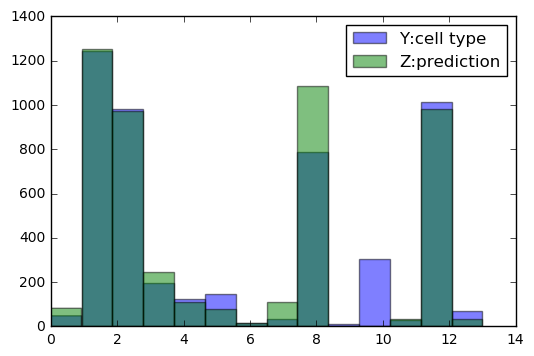

In [50]:
# vote, and compute accuracy

threshold = -113888.425449/data.shape[0]*N  - 10000000000
# keep that samples whose likelihood is above threshold
burnt_samples = []
burnt_predictions = []
for i in range(len(accepts)):
    accepted_chain = accepts[i]
    likelihoods = logl_accepted_trace[i]
    predictions = Y_predict_accepted_trace[i]
    burnt_samples += [accepted_chain[_] for _ in range(len(accepted_chain)) if likelihoods[_] > threshold]
    burnt_predictions += [predictions[_] for _ in range(len(accepted_chain)) if likelihoods[_] > threshold]
    
# vote
votes = np.zeros([data_subset.shape[0], table.shape[0]])
for Y_predict in burnt_predictions:
    for _ in range(len(Y_predict)):
        votes[_,Y_predict[_]] += 1

Y_predict_majority = np.argmax(votes, axis=1)

print votes.sum()

accuracy = sum(Y_subset == Y_predict_majority)*1.0/ data_subset.shape[0]
print "Chain % d accuracy on subset data: %.3f" % (chain+1,accuracy)

bins = table.shape[0]
plt.hist(Y_subset, bins, alpha=0.5, label='Y:cell type')
plt.hist(Y_predict_majority, bins, alpha=0.5, label='Z:prediction')
plt.legend(loc='upper right')
plt.show() 

50000.0
Chain  5 accuracy on subset data: 0.691


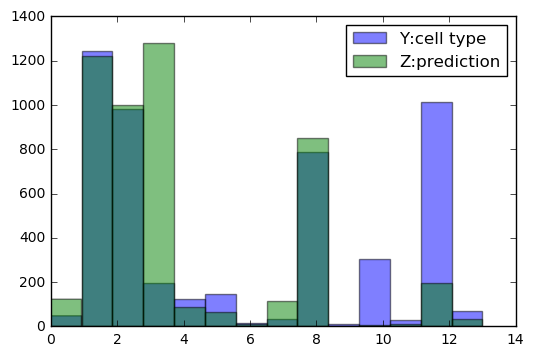

In [51]:
# emsemble 100 samples from prior

# vote
votes = np.zeros([data_subset.shape[0], table.shape[0]])

for i in range(n_mcmc_chain):
    Y_predict = Y_predict_accepted_trace[i][0]
    for _ in range(len(Y_predict)):
        votes[_,Y_predict[_]] += 1

Y_predict_majority = np.argmax(votes, axis=1)

print votes.sum()

accuracy = sum(Y_subset == Y_predict_majority)*1.0/ data_subset.shape[0]
print "Chain % d accuracy on subset data: %.3f" % (chain+1,accuracy)

bins = table.shape[0]
plt.hist(Y_subset, bins, alpha=0.5, label='Y:cell type')
plt.hist(Y_predict_majority, bins, alpha=0.5, label='Z:prediction')
plt.legend(loc='upper right')
plt.show() 

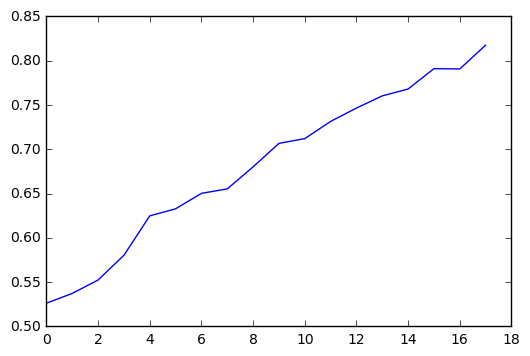

In [52]:
L = min(len(_) for _ in accuracy_accepted_trace)
res = []
for i in range(L):
    res.append(np.array([_[i] for _ in accuracy_accepted_trace]).mean())
plt.plot(res)

29
Chain  5 accuracy on subset data: 0.911


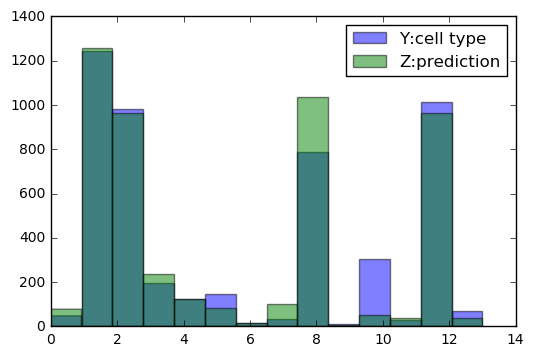

In [55]:
# vote, and compute accuracy

threshold = -113888.425449/data.shape[0]*N  - 10000000000
# keep that samples whose likelihood is above threshold
burnt_samples = []
burnt_predictions = []
for i in range(len(accepts)):
    accepted_chain = accepts[i]
    likelihoods = logl_accepted_trace[i]
    predictions = Y_predict_accepted_trace[i]
    burnt_samples += [accepted_chain[_] for _ in range(22, len(accepted_chain))]
    burnt_predictions += [predictions[_] for _ in range(22, len(accepted_chain))]
    
# vote
votes = np.zeros([data_subset.shape[0], table.shape[0]])
for Y_predict in burnt_predictions:
    for _ in range(len(Y_predict)):
        votes[_,Y_predict[_]] += 1

Y_predict_majority = np.argmax(votes, axis=1)

print len(burnt_predictions)

accuracy = sum(Y_subset == Y_predict_majority)*1.0/ data_subset.shape[0]
print "Chain % d accuracy on subset data: %.3f" % (chain+1,accuracy)

bins = table.shape[0]
plt.hist(Y_subset, bins, alpha=0.5, label='Y:cell type')
plt.hist(Y_predict_majority, bins, alpha=0.5, label='Z:prediction')
plt.legend(loc='upper right')
plt.show() 